# Importing Libraries

In [1]:
import pandas as pd
import pyodbc 
import numpy as np
import pickle as pkl
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import KFold



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 500)             
pd.set_option('display.expand_frame_repr', False)

 # Connecting to Database 

In [2]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-RJIS3LA;'
                      'Database=AdventureWorksDW2022;'
                      'Trusted_Connection=yes;')


sql_for_df = "SELECT * FROM pbi_np_recommendation_data"

df = pd.read_sql(sql_for_df , conn) 
conn.close()

C:\Users\Joseph Aromeh\AppData\Local\Temp\ipykernel_9900\2883525119.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_for_df , conn)


# Exploratory Data Analysis

This EDA task is amied at uncovering product-product relationships, product-customer relationships as well as customer-customer relationships.

The initial phase of the EDA will be simply exploring the data to understand the distributions of the dataset. This is intended to lead to the original intent of the EDA as stated above

In [3]:
pivot_df = pd.pivot_table(df, 
                          index=['CustomerKey', 'ProductKey', 'MaritalStatus', 'Gender', 'Education', 
                                 'Occupation', 'Income Segment', 'TotalChildren', 'Age Group', 'NumberChildrenAtHome', 
                                 'HouseOwnerFlag', 'NumberCarsOwned'],
                          
                          columns='Product',
                          
                          values='OrderQuantity',
                          
                          aggfunc='sum',
                          
                          fill_value=0).reset_index()

# Flatten the MultiIndex columns
pivot_df.columns = [col[1] if col[1] != '' else col[0] for col in pivot_df.columns]

# Reset the index to make 'Product' a regular column
pivot_df.reset_index(inplace=True)

In [4]:
pivot_df.head()

,index,u,r,a,e,d,c,n,o,g,u,o,u,W,l,i,l,l,l,e,L,L,a,a,a,i,y,L,L,o,o,o,o,L,L,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,a,a,a,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,h,h,h,h,p,p,p,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,o,a,o,o,o
0,0,11000,214,M,M,Bachelors,Professional,Mid Income,1-2 kids,41-50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,11000,344,M,M,Bachelors,Professional,Mid Income,1-2 kids,41-50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,11000,353,M,M,Bachelors,Professional,Mid Income,1-2 kids,41-50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,11000,485,M,M,Bachelors,Professional,Mid Income,1-2 kids,41-50,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,11000,488,M,M,Bachelors,Professional,Mid Income,1-2 kids,41-50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


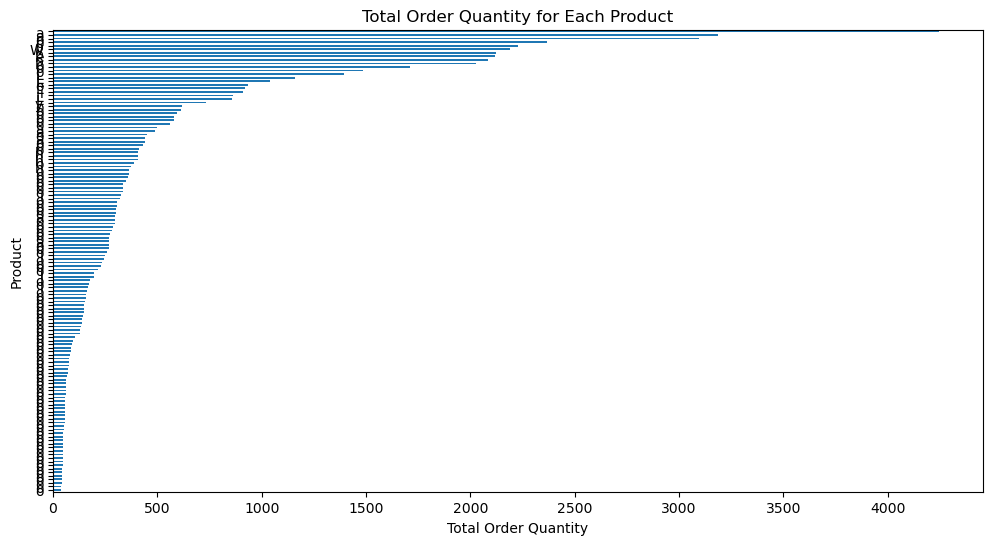

In [5]:
# Total order quantity for each product
total_quantity_per_product = pivot_df.iloc[:, 13:].sum()

# Bar chart for total order quantity per product
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
total_quantity_per_product.sort_values().plot(kind='barh')
plt.title('Total Order Quantity for Each Product')
plt.xlabel('Total Order Quantity')
plt.ylabel('Product')
plt.show()



In [12]:
products = df[['CustomerKey', 'Product', 'ProductCategory', 'ProductSubcategory', 'OrderQuantity', 'LargePhoto']]

# Transforming the Dataset

In [14]:
pro = products.pivot_table(index='CustomerKey', columns='Product', values='OrderQuantity', fill_value=0)

Create a pivot taable to have a summary view of the relationships between customers and products. The table is orginized based on customer keys and product keys, with the order quantities as the values. Any missing values are filled with zeros. 

In [15]:
pro.head()

Product,AWC Logo Cap,All-Purpose Bike Stand,Bike Wash - Dissolver,"Classic Vest, L","Classic Vest, M","Classic Vest, S",Fender Set - Mountain,HL Mountain Tire,HL Road Tire,"Half-Finger Gloves, L","Half-Finger Gloves, M","Half-Finger Gloves, S",Hitch Rack - 4-Bike,Hydration Pack - 70 oz.,LL Mountain Tire,LL Road Tire,"Long-Sleeve Logo Jersey, L","Long-Sleeve Logo Jersey, M","Long-Sleeve Logo Jersey, S","Long-Sleeve Logo Jersey, XL",ML Mountain Tire,ML Road Tire,Mountain Bottle Cage,Mountain Tire Tube,"Mountain-100 Black, 38","Mountain-100 Black, 42","Mountain-100 Black, 44","Mountain-100 Black, 48","Mountain-100 Silver, 38","Mountain-100 Silver, 42","Mountain-100 Silver, 44","Mountain-100 Silver, 48","Mountain-200 Black, 38","Mountain-200 Black, 42","Mountain-200 Black, 46","Mountain-200 Silver, 38","Mountain-200 Silver, 42","Mountain-200 Silver, 46","Mountain-400-W Silver, 38","Mountain-400-W Silver, 40","Mountain-400-W Silver, 42","Mountain-400-W Silver, 46","Mountain-500 Black, 40","Mountain-500 Black, 42","Mountain-500 Black, 44","Mountain-500 Black, 48","Mountain-500 Black, 52","Mountain-500 Silver, 40","Mountain-500 Silver, 42","Mountain-500 Silver, 44","Mountain-500 Silver, 48","Mountain-500 Silver, 52",Patch Kit/8 Patches,"Racing Socks, L","Racing Socks, M",Road Bottle Cage,Road Tire Tube,"Road-150 Red, 44","Road-150 Red, 48","Road-150 Red, 52","Road-150 Red, 56","Road-150 Red, 62","Road-250 Black, 44","Road-250 Black, 48","Road-250 Black, 52","Road-250 Black, 58","Road-250 Red, 44","Road-250 Red, 48","Road-250 Red, 52","Road-250 Red, 58","Road-350-W Yellow, 40","Road-350-W Yellow, 42","Road-350-W Yellow, 44","Road-350-W Yellow, 48","Road-550-W Yellow, 38","Road-550-W Yellow, 40","Road-550-W Yellow, 42","Road-550-W Yellow, 44","Road-550-W Yellow, 48","Road-650 Black, 44","Road-650 Black, 48","Road-650 Black, 52","Road-650 Black, 58","Road-650 Black, 60","Road-650 Black, 62","Road-650 Red, 44","Road-650 Red, 48","Road-650 Red, 52","Road-650 Red, 58","Road-650 Red, 60","Road-650 Red, 62","Road-750 Black, 44","Road-750 Black, 48","Road-750 Black, 52","Road-750 Black, 58","Short-Sleeve Classic Jersey, L","Short-Sleeve Classic Jersey, M","Short-Sleeve Classic Jersey, S","Short-Sleeve Classic Jersey, XL","Sport-100 Helmet, Black","Sport-100 Helmet, Blue","Sport-100 Helmet, Red",Touring Tire,Touring Tire Tube,"Touring-1000 Blue, 46","Touring-1000 Blue, 50","Touring-1000 Blue, 54","Touring-1000 Blue, 60","Touring-1000 Yellow, 46","Touring-1000 Yellow, 50","Touring-1000 Yellow, 54","Touring-1000 Yellow, 60","Touring-2000 Blue, 46","Touring-2000 Blue, 50","Touring-2000 Blue, 54","Touring-2000 Blue, 60","Touring-3000 Blue, 44","Touring-3000 Blue, 50","Touring-3000 Blue, 54","Touring-3000 Blue, 58","Touring-3000 Blue, 62","Touring-3000 Yellow, 44","Touring-3000 Yellow, 50","Touring-3000 Yellow, 54","Touring-3000 Yellow, 58","Touring-3000 Yellow, 62",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S"
CustomerKey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11001,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

Above, we have a snapshot of customer preferences and buying patterns across various biking-related product categories. We can see the quantity of items purchased by each customer in each category.

In [16]:
pro.shape

(18484, 130)

In [17]:
train_data, test_data = train_test_split(pro, test_size=0.2, random_state=42)

**We perform a cosine-similarity to weigh the similarities among users in the train dataset by their profiles**

Calculate the cosine similarity between users using the training data (train_data)

In [18]:
user_similarity = cosine_similarity(train_data)
user_similarity[5]

array([0.16666667, 0.33333333, 0.23570226, ..., 0.        , 0.        ,
       0.        ])

**We then convert the result to a dataframe and insert that into the variable "user_df"**

In [19]:
user_df = pd.DataFrame(user_similarity, index=train_data.index, columns=train_data.index)

In [20]:
# user_df.head()

In [21]:
user_df.shape

(14787, 14787)

* Add product association analysis Product (create a pseudo key for some customers)

* Cost attributes Customer Focused Recommendation


In [22]:
def recommend(user_key):
    # Checks if a CustomerKey is in index and returns 0 for non-existing Keys
    if user_key not in train_data.index:
        return pd.DataFrame(index=train_data.columns, data={'Product': 0.0, 'WeightedAverage': 0.0})

    user_history = train_data.loc[user_key] # Get the user's purchase history if Key exists
    weighted_sum = user_df.loc[user_key] @ train_data # Get the weighted sum of purchase frequencies based on similarity
    recommendations = weighted_sum[~user_history.astype(bool)] # Exclude items that the user has already purchased
    recommendations = recommendations.sort_values(ascending=False)
    recommendations_df = pd.DataFrame({'Product': recommendations.index, 'Likely_Preference': recommendations.values})

    return recommendations_df

In [23]:
def recommendation_metric(test_data, user_df, train_data):
    all_rmse = []
    all_mae = []

    for user_key in test_data.index:
        # Get the recommendations for the user
        recommendations = recommend(user_key)  

        # Get the actual purchase frequencies from the test set
        actual_frequencies = test_data.loc[user_key]

        # Keep only the recommendations present in the test set
        relevant_recommendations = recommendations['Product'].index.intersection(actual_frequencies.index)

        # Calculate RMSE and MAE
        rmse = np.sqrt(mean_squared_error(actual_frequencies[relevant_recommendations], recommendations['WeightedAverage'][relevant_recommendations]))
        mae = mean_absolute_error(actual_frequencies[relevant_recommendations], recommendations['WeightedAverage'][relevant_recommendations])

        all_rmse.append(rmse)
        all_mae.append(mae)

    # Calculate the mean RMSE and MAE across all users
    mean_rmse = np.mean(all_rmse)
    mean_mae = np.mean(all_mae)
    

    return mean_rmse, mean_mae

In [24]:
# Test the recommendation function for a specific user
user = 11004
recommendations = recommend(user)

# Display the top N recommendations
top_n_recommendations = recommendations['Product'].head(5)
print(f'Below are your most likely products \n{top_n_recommendations}')

Below are your most likely products 
0    Water Bottle - 30 oz.
1       Mountain Tire Tube
2     Mountain Bottle Cage
3             AWC Logo Cap
4           Road Tire Tube
Name: Product, dtype: object


In [25]:
# Evaluate the recommendation engine on the test set
mean_rmse, mean_mae = recommendation_metric(test_data, user_df, train_data)
print(f"\nMean RMSE: {mean_rmse}")
print(f"Mean MAE: {mean_mae}")


Mean RMSE: 0.15030046619848988
Mean MAE: 0.02433782068621127


In [26]:
pkl.dump(products, open('Products.pkl', 'wb'))

pkl.dump(user_similarity, open('user_similarity.pkl', 'wb'))